In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import tensorflow as tf
import tensorflow.keras.layers as layers

2024-05-08 00:31:49.317689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 00:31:49.317827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 00:31:49.453405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def display_data(dataset, count):
    
    images = glob.glob(f'/kaggle/input/lyft-udacity-challenge/{dataset}/{dataset}/CameraRGB/*.png')[:count]
    masks = glob.glob(f'/kaggle/input/lyft-udacity-challenge/{dataset}/{dataset}/CameraSeg/*.png')[:count]
    
    for i in range(len(images)):
        images[i] = cv2.imread(images[i])
        masks[i] = cv2.imread(masks[i], cv2.IMREAD_GRAYSCALE)
        
    fig, axes = plt.subplots(count, 2)
    
    for i in range(len(images)):
        axes[i][0].imshow(images[i])
        axes[i][1].imshow(masks[i])
        
    plt.show()

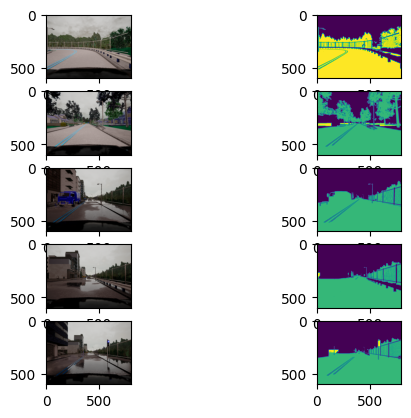

In [3]:
display_data('dataA', 5)

In [4]:
images = []
masks = []
def store_data(dataset):
    images.append(glob.glob(f'/kaggle/input/lyft-udacity-challenge/{dataset}/{dataset}/CameraRGB/*.png'))
    masks.append(glob.glob(f'/kaggle/input/lyft-udacity-challenge/{dataset}/{dataset}/CameraSeg/*.png'))

In [5]:
store_data('dataA')
store_data('dataB')
store_data('dataC')
store_data('dataD')
store_data('dataE')

In [6]:
def convert_to_1d(dataset):
    temp = []
    for sublist in dataset:
        temp.extend(sublist)
    return temp

In [7]:
images = convert_to_1d(images)
masks = convert_to_1d(masks)

In [8]:
image_dataset = tf.data.Dataset.list_files(images, shuffle=False)
mask_dataset = tf.data.Dataset.list_files(masks, shuffle=False)

In [9]:
image_names = tf.constant(images)
mask_names = tf.constant(masks)
dataset = tf.data.Dataset.from_tensor_slices((image_names, mask_names))

In [10]:
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return image, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (192, 256), method='nearest')
    input_mask = tf.image.resize(mask, (192, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

# UNet

In [11]:
def conv_block(inputs, num_filters):
    conv = layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    return conv

In [12]:
def conv(inputs, num_filters):
    layer = conv_block(inputs, num_filters)
    layer = layers.BatchNormalization(axis=3)(layer, training=True)
    layer = layers.ReLU()(layer)
    return layer

## Encoder

In [13]:
def downsample_block(inputs, num_filters, dropout=0, max_pooling=True):
    layer = conv(inputs, num_filters)
    layer = conv(layer, num_filters)
    
    if dropout > 0:
        layer = layers.Dropout(dropout)(layer)
    skip = layer
    if max_pooling:
        layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    next_layer = layer
    
    return next_layer, skip
        

## Decoder

In [14]:
def upsample_block(inputs, skip, num_filters):
    layer = layers.Conv2DTranspose(num_filters, 3, strides=(2,2), padding='same')(inputs)
    layer = layers.concatenate([layer, skip], axis=3)
    layer = conv(layer, num_filters)
    layer = conv(layer, num_filters)
    return layer

## Combining everything to build a UNet

In [21]:
def build_unet(input_size=(192,256,3), num_filters=32, num_classes=13):
    inputs = layers.Input(input_size)
    
    p1, s1 = downsample_block(inputs, num_filters)
    p2, s2 = downsample_block(p1, num_filters * 2)
    p3, s3 = downsample_block(p2, num_filters * 4)
    p4, s4 = downsample_block(p3, num_filters * 8, dropout=0.3)
    
    b1 = downsample_block(p4, num_filters * 16, dropout=0.3, max_pooling=False)
    
    d1 = upsample_block(b1[0], s4, num_filters * 8)
    d2 = upsample_block(d1, s3, num_filters * 4)
    d3 = upsample_block(d2, s2, num_filters * 2)
    d4 = upsample_block(d3, s1, num_filters)
    
    output_layer = layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    output_layer = layers.BatchNormalization(axis=3)(output_layer, training=True)
    output_layer = layers.ReLU()(output_layer)
    output_layer = layers.Conv2D(num_classes, 1, padding='same')(output_layer)
    output_layer = layers.BatchNormalization(axis=3)(output_layer, training=True)
    output_layer = layers.ReLU()(output_layer)
    
    model = tf.keras.Model(inputs=inputs, outputs=output_layer)
    return model

In [22]:
unet = build_unet()

In [23]:
unet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 192, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 192, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 192, 256,  │      9,248 │ re_lu_20[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 192, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 96, 128,   │          0 │ re_lu_21[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 96, 128,   │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 96, 128,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 96, 128,   │     36,928 │ re_lu_22[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 96, 128,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 48, 64,    │          0 │ re_lu_23[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 48, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │        512 │ conv2d_24[0][0] 

 Total params: 8,652,097 (33.01 MB)

 Trainable params: 8,646,119 (32.98 MB)

 Non-trainable params: 5,978 (23.35 KB)

In [24]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [25]:
EPOCHS = 50
BUFFER_SIZE = 1000
BATCH_SIZE = 64
map_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# Splitting data to training set and val set
num_samples = map_dataset.reduce(0, lambda x, _: x + 1).numpy()
train_dataset = map_dataset.take(int(0.8 * num_samples))
val_dataset = map_dataset.skip(int(0.8 * num_samples))
print(processed_image_ds)
# ReduceLROnPlateau and EarlyStopping callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=1, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(patience=2)

<_MapDataset element_spec=(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))>


In [27]:
model_performance = unet.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[reduce_lr,early_stop])

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 546ms/step - accuracy: 0.9303 - loss: 0.8047 - val_accuracy: 0.5077 - val_loss: 1.9830 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 546ms/step - accuracy: 0.9436 - loss: 0.7019 - val_accuracy: 0.5387 - val_loss: 1.8995 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 546ms/step - accuracy: 0.9512 - loss: 0.6239 - val_accuracy: 0.7562 - val_loss: 1.2593 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 547ms/step - accuracy: 0.9572 - loss: 0.5544 - val_accuracy: 0.8264 - val_loss: 0.9085 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 547ms/step - accuracy: 0.9620 - loss: 0.4978 - val_accuracy: 0.9381 - val_loss: 0.5374 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 546ms/step - accuracy: 0.9649 - loss: 0.4500 - val_accuracy: 0.9595 - val_loss: 0.4368 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 546ms/step - accuracy: 0.9674 - loss: 0.

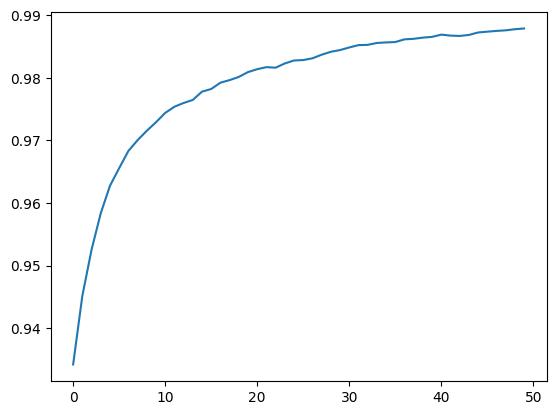

In [28]:
plt.plot(model_performance.history["accuracy"])

In [31]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [34]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


In [35]:
def show_predictions(unet = unet, dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


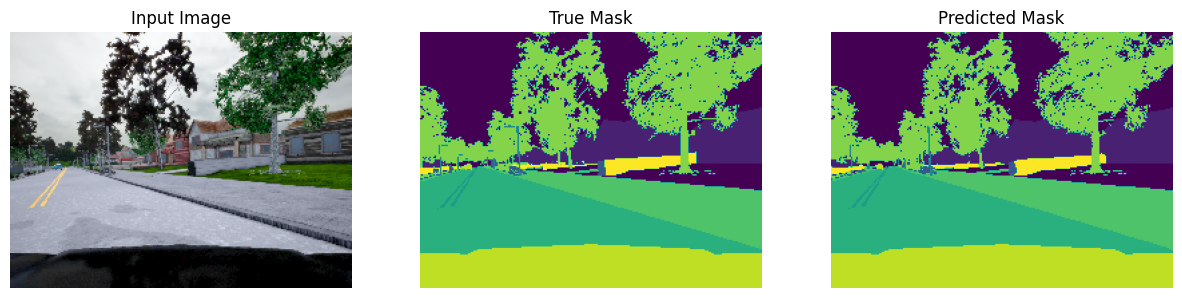

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


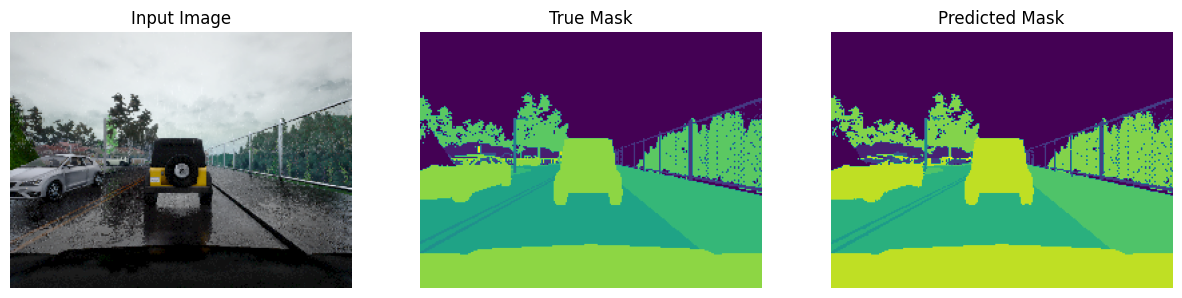

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


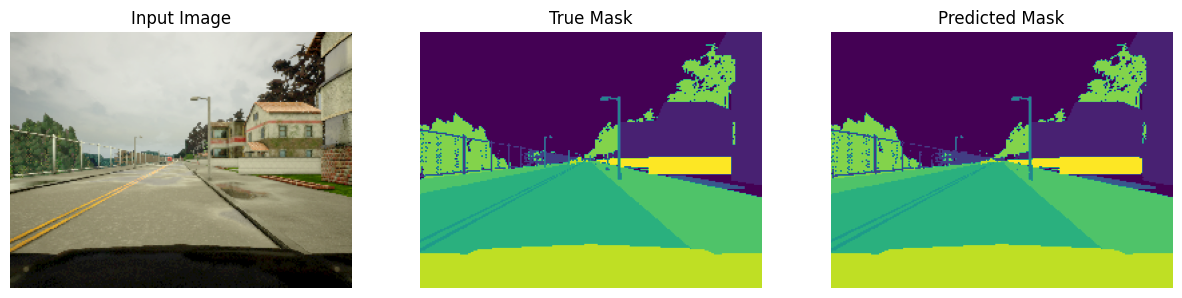

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


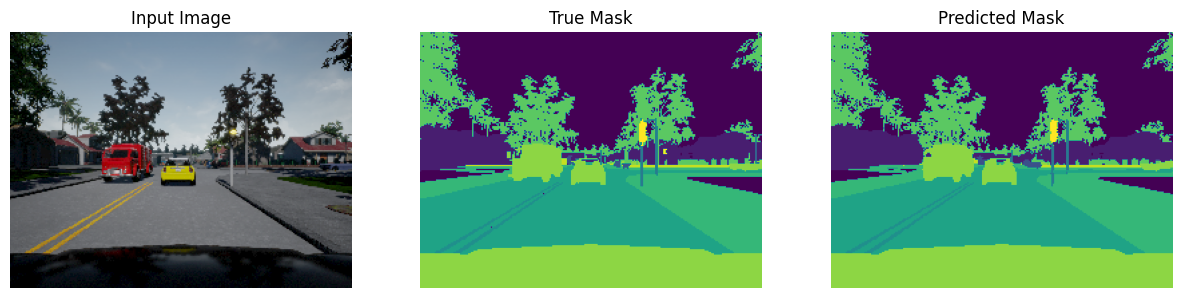

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


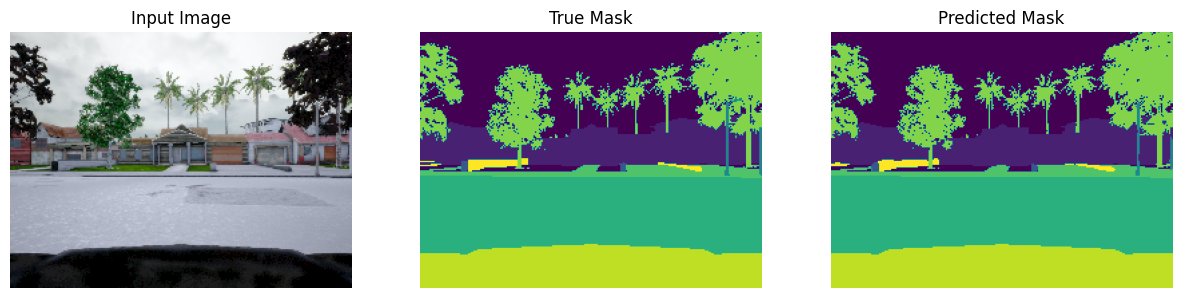

In [36]:
show_predictions(unet, train_dataset, 5)

In [37]:
tf.keras.models.save_model(unet, '/kaggle/working/model.h5')